# Generic case

In this tutorial, we show how to start with a generic scRNA-seq dataset with multiple cell types. To demonstrate the accuraty of `TOMAS`, we use a simulated dataset with ground truth of total-mRNA ratios between cell types.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import tomas as tm

load and analyze data with `scanpy`

Download the file `adata_mc.h5ad` from our [repo](https://github.com/QiuyuLian/TOMAS/blob/main/examples/simulated_data/adata_mc.h5ad).

In [2]:
adata = sc.read_h5ad('examples/simulated_data/adata_mc.h5ad')

## Computational doublet detection

Load putative doublets detected by computational doublet detection methods. Here we use `R` package [DoubletCollection](https://github.com/xnnba1984/DoubletCollection), which integrates multiple computational doublet-detection methods, for doublet detection. The benchmarking of different doublet detection methods and execution of `DoubletCollection` package could see Dobulet Detection [tutorial](https://github.com/QiuyuLian/TOMAS/blob/main/examples/simulated_data/doublet-detection.R).

In [3]:
dbl_pred = pd.read_csv('examples/simulated_data/dbl_pred_DoubletFinder.txt',header=None,index_col=None)
dbl_pred.head(3)

,0
0,d_0
1,d_7
2,d_10


In [4]:
adata.obs['droplet_type'] = 'Homotypic'
adata.obs.loc[np.ravel(dbl_pred),'droplet_type'] = 'Heterotypic'

Clutering putative singlets to identify cell types following the [clutering tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) of `scanpy`. We recommand not performing global normalization step.

## Homotypic droplet population identification

In [5]:
sc.settings.verbosity = 3            
sc.settings.set_figure_params(dpi=60, facecolor='white')

In [6]:
adata_psgl = adata[adata.obs['droplet_type']=='Homotypic'].copy()

adata_psgl.obs['n_counts'] = np.ravel(adata_psgl.X.sum(1))
sc.pp.filter_cells(adata_psgl, min_genes=1)
sc.pp.filter_genes(adata_psgl, min_cells=1)

sc.pp.log1p(adata_psgl)
sc.pp.highly_variable_genes(adata_psgl, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_psgl.raw = adata_psgl
adata_psgl = adata_psgl[:, adata_psgl.var.highly_variable]
sc.pp.regress_out(adata_psgl, ['n_counts']) ##
sc.pp.scale(adata_psgl, max_value=10)
sc.tl.pca(adata_psgl, svd_solver='arpack')
sc.pp.neighbors(adata_psgl, n_neighbors=10, n_pcs=40)


filtered out 2886 genes that are detected in less than 1 cells
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['n_counts']
/home/qy/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'droplet_type' as categorical
    finished (0:00:10)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


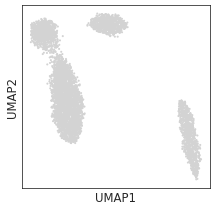

In [7]:
sc.tl.umap(adata_psgl)
sc.pl.umap(adata_psgl)


running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


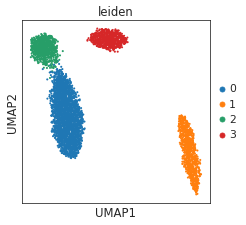

In [8]:
sc.tl.leiden(adata_psgl, resolution=0.1)
sc.pl.umap(adata_psgl, color=['leiden'])

(optional) Annotate cell clusters with domain knowledge of cell-type-specific transcriptomic markers. This step is optional. `TOMAS` could aslo be applied to infer total-mRNA ratioes between identified cell clusters.

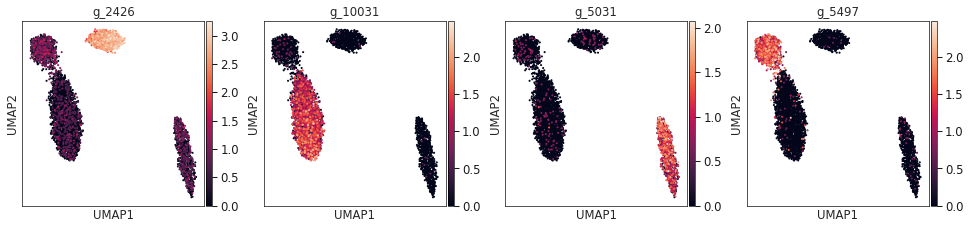

In [9]:
sc.pl.umap(adata_psgl, color=['g_2426','g_10031','g_5031','g_5497'],ncols=5)


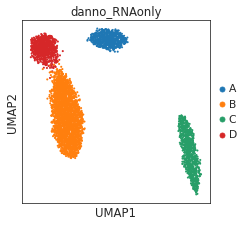

In [10]:
ct_mapper = {}
ct_mapper['3']='A'   # g_2426
ct_mapper['0']='B'   # g_10031
ct_mapper['1']='C'   # g_5031
ct_mapper['2']='D'   # g_5497

adata_psgl.obs['danno_RNAonly'] = pd.Categorical([ct_mapper[g] for g in adata_psgl.obs['leiden']],
                                                               categories=ct_mapper.values())

sc.pl.umap(adata_psgl, color=['danno_RNAonly'])

**Key**: save identified cell cluters/types as mandatory inputs for `TOMAS`

In [11]:
adata.obs['danno_RNAonly'] = 'unknown'
adata.obs.loc[adata_psgl.obs_names,'danno_RNAonly'] = adata_psgl.obs['danno_RNAonly'].values


## Hetero-doublets identification and refinement 

Detect genes specifically highly expressed in each cell type. 

In [12]:
sc.tl.rank_genes_groups(adata_psgl, 'danno_RNAonly', method='wilcoxon')
degene_sorted = tm.auxi.extract_specific_genes(adata_psgl, 'danno_RNAonly')


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


Identified heterotypic doublets expressing specific genes of both component cell types. 

If you don't want display the process one by one, you could run the code below to detect all kinds of heterotypic doublets one time:

Detect doublets composed by cell type A and B.


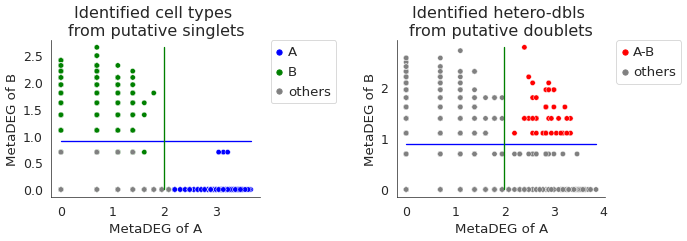

3 putative heterotypic doublets detected.
Detect doublets composed by cell type A and C.


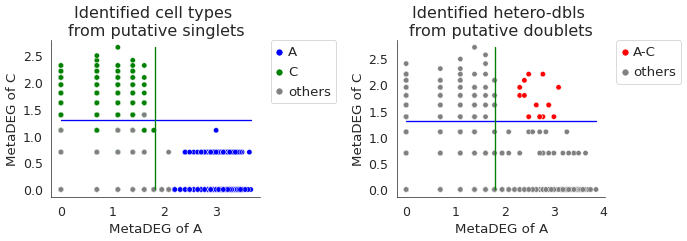

3 putative heterotypic doublets detected.
Detect doublets composed by cell type A and D.


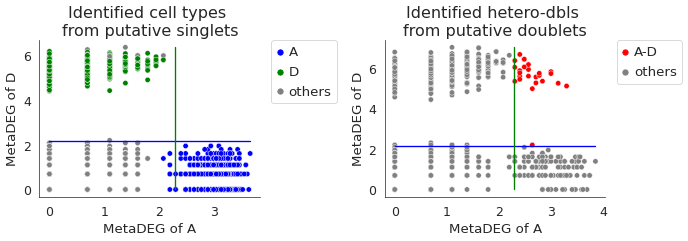

3 putative heterotypic doublets detected.
Detect doublets composed by cell type B and C.


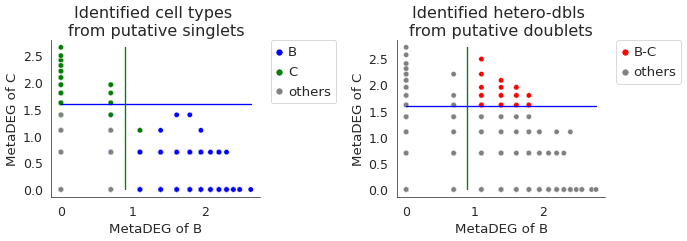

3 putative heterotypic doublets detected.
Detect doublets composed by cell type B and D.


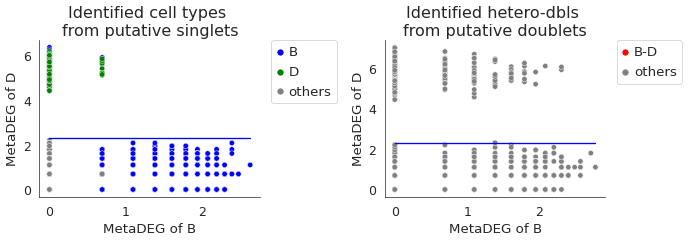

3 putative heterotypic doublets detected.
Detect doublets composed by cell type C and D.


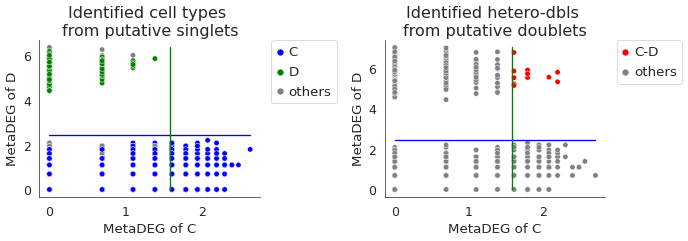

3 putative heterotypic doublets detected.


In [13]:
tm.infer.heteroDbl(adata, 
                   d_groupby = 'droplet_type', 
                   ct_groupby = 'danno_RNAonly',
                   de_sorted = degene_sorted,
                   dbl_groupby = 'heteroDbl',
                   vis=True)


The automiative detection threshold might fail in some cases, especially when outliers occur. We also provide API to mannual ajustment of the thresholds to detect heterotypic doublets, 

Below we showcase how to adjust in "A_D" and "B_D".

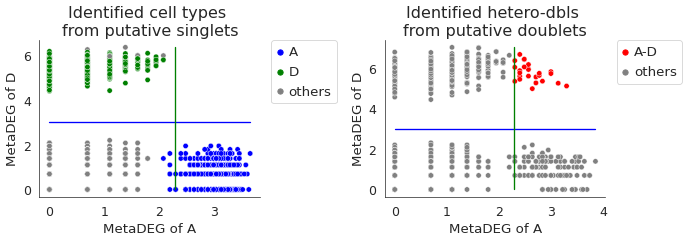

In [14]:
dbl = 'A_D'

dbl_candidate = tm.infer.heteroDbl_bc(adata, 
                                          dbl, 
                                          d_groupby = 'droplet_type', 
                                          ct_groupby = 'danno_RNAonly',
                                          threshold_y = 3,
                                          de_sorted = degene_sorted)


Then we earse the original results with automative thresholds and update

In [15]:
adata.obs.loc[adata.obs['heteroDbl']==dbl,'heteroDbl'] = 'unknown'
adata.obs.loc[dbl_candidate,'heteroDbl'] = dbl

Another example 

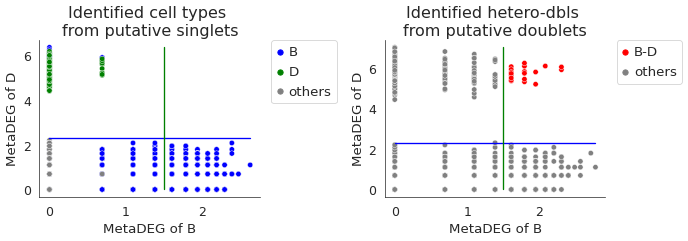

In [16]:
dbl = 'B_D'

dbl_candidate = tm.infer.heteroDbl_bc(adata, 
                                          dbl, 
                                          d_groupby = 'droplet_type', 
                                          ct_groupby = 'danno_RNAonly',
                                          threshold_x = 1.5,
                                          de_sorted = degene_sorted)

In [17]:
adata.obs.loc[adata.obs['heteroDbl']==dbl,'heteroDbl'] = 'unknown'
adata.obs.loc[dbl_candidate,'heteroDbl'] = dbl

Summary of the heterotypic doublets

In [18]:
np.unique(adata.obs['heteroDbl'], return_counts=True)

(array(['A_B', 'A_C', 'A_D', 'B_C', 'B_D', 'C_D', 'unknown'], dtype=object),
 array([  43,   12,   25,   26,   19,   12, 5935]))

## Fit signature distribution for each cell type

In [19]:
tm.fit.dmn(adata,
           groupby='danno_RNAonly',
           groups=['A','B','C','D'],
           verbose=2,
           verbose_interval = 100)

Initialization 0
Initialization 0
Initialization 0
Initialization 0
  Iteration 100	 time lapse 23.98463s	 ll change 0.01511
  Iteration 100	 time lapse 31.85653s	 ll change 0.03919
  Iteration 100	 time lapse 33.85745s	 ll change 0.07604
  Iteration 200	 time lapse 23.02100s	 ll change 0.00144
Initialization converged: True	 time lapse 51.64538s	 ll -9807.11887
A is done!
Initialization converged: True	 time lapse 53.89664s	 ll -13517.22824
B is done!
  Iteration 200	 time lapse 30.59079s	 ll change 0.00148
  Iteration 200	 time lapse 32.55131s	 ll change 0.00867
Initialization converged: True	 time lapse 66.64009s	 ll -37159.59384
D is done!
  Iteration 300	 time lapse 31.96321s	 ll change 0.00196
Initialization converged: True	 time lapse 115.60594s	 ll -25138.43835
C is done!


## Infer total-mRNA ratios

In [20]:
adata.obs['total_UMIs'] = np.ravel(adata.X.sum(1))
adata.obs['log10_totUMIs'] = np.log10(adata.obs['total_UMIs'])
tm.fit.logN_para(adata,
                 logUMIby='log10_totUMIs',
                 groupby='danno_RNAonly',
                 inplace=True)

In [21]:
adata_mgdic = tm.infer.get_dbl_mg(adata, groupby='heteroDbl')

A_B
Initialized.
Iteration 2	time lapse 6.110735893249512s	ll change 59.60056613502093

Iteration 4	time lapse 6.059990167617798s	ll change 0.0562097267320496

Iteration 6	time lapse 6.063108682632446s	ll change 0.0026154997176490724



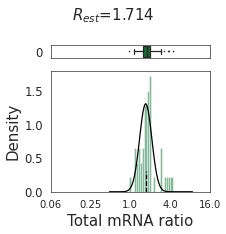

A_D
Initialized.
Iteration 2	time lapse 3.592271566390991s	ll change 260.3046546783371

Iteration 4	time lapse 3.6289291381835938s	ll change 1.2029229833206045

Iteration 6	time lapse 3.5764691829681396s	ll change 0.16325577144743875

Iteration 8	time lapse 3.597684144973755s	ll change 0.0890423650489538

Iteration 10	time lapse 3.6554698944091797s	ll change 0.04176003468455747

Iteration 12	time lapse 3.6059939861297607s	ll change 0.0013589796872111037

Iteration 14	time lapse 3.5850698947906494s	ll change 0.01844252090086229

Iteration 16	time lapse 3.6317148208618164s	ll change 0.0



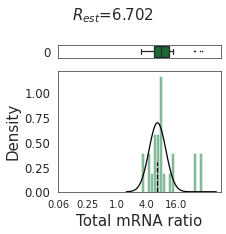

A_C
Initialized.
Iteration 2	time lapse 1.855905294418335s	ll change 10.26244620365469

Iteration 4	time lapse 1.8606882095336914s	ll change 0.00970379095087992

Iteration 6	time lapse 1.9068949222564697s	ll change 0.000951556270592846



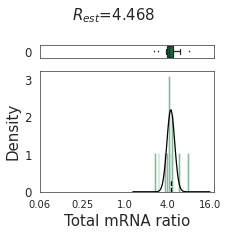

B_D
Initialized.
Iteration 2	time lapse 2.8245959281921387s	ll change 97.44699023737849

Iteration 4	time lapse 2.805579662322998s	ll change 0.02438904058726621

Iteration 6	time lapse 2.78024959564209s	ll change 0.010696593020838918



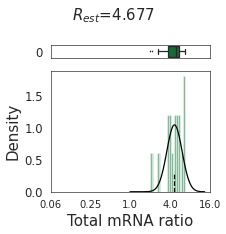

B_C
Initialized.
Iteration 2	time lapse 3.731433629989624s	ll change 136.77680502508156

Iteration 4	time lapse 3.7355246543884277s	ll change 0.2910213137147366

Iteration 6	time lapse 3.7788748741149902s	ll change 0.004609695628460031

Iteration 8	time lapse 3.7713003158569336s	ll change 0.0008551109713152982



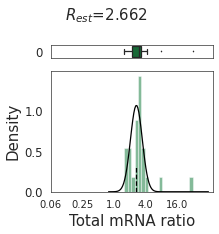

C_D
Initialized.
Iteration 2	time lapse 1.8745081424713135s	ll change 425.93514247591884

Iteration 4	time lapse 1.8366658687591553s	ll change 1.522558455246326

Iteration 6	time lapse 1.9022727012634277s	ll change 0.0



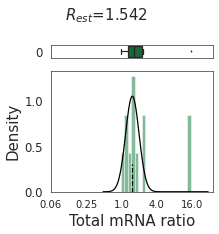

In [24]:
for dbl in adata_mgdic:
    print(dbl)
    
    tm.infer.ratios_bc(adata_mgdic[dbl],dbl,verbose=1)
    w_best = adata_mgdic[dbl].uns['ratio']['w_best']
    tm.vis.logRatio_dist((1-w_best)/w_best)

## Compare with simulation ground truth

In [25]:
dbl_groups = list(adata_mgdic.keys())

In [26]:
for i in range(len(dbl_groups)):
    
    dbl = dbl_groups[i]

    log2R_true = np.log2(adata.obs.loc[adata.obs['heteroDbl']==dbl,'trueR'])
    w_best = adata_mgdic[dbl].uns['ratio']['w_best']
    log2R_pred = np.log2((1-w_best)/w_best)
    
    trueR = 2**np.mean(tm.auxi.rm_outliers(log2R_true[~np.isnan(log2R_true)]))
    predR = 2**np.mean(tm.auxi.rm_outliers(log2R_pred))
    err = trueR - predR
    print(dbl,'true R=',trueR,', predicted R=',predR,', err=',err)

A_B true R= 1.740032658434202 , predicted R= 1.7141392089316896 , err= 0.02589344950251249
A_D true R= 6.453011210546609 , predicted R= 6.701903630039334 , err= -0.24889241949272556
A_C true R= 4.36453053893642 , predicted R= 4.468157233806065 , err= -0.10362669486964471
B_D true R= 4.507771530493424 , predicted R= 4.6769596654388845 , err= -0.16918813494546026
B_C true R= 2.9659917919117658 , predicted R= 2.6619621980460826 , err= 0.3040295938656832
C_D true R= 1.6045277891932905 , predicted R= 1.5419451474160566 , err= 0.06258264177723394


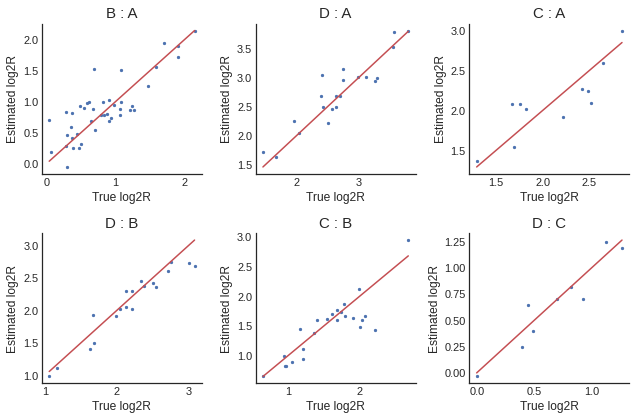

In [32]:
from matplotlib import pyplot as plt

plt.figure(figsize=(9,3*np.ceil(len(dbl_groups) / 3)), dpi=72)
plt.style.use('seaborn-white')
for i in range(len(dbl_groups)):
    ax = plt.subplot(int(np.ceil(len(dbl_groups)/3)),3,i+1)
    
    dbl = dbl_groups[i]

    log2R_true = np.log2(adata.obs.loc[adata.obs['heteroDbl']==dbl,'trueR'])
    w_best = adata_mgdic[dbl].uns['ratio']['w_best']
    log2R_pred = np.log2((1-w_best)/w_best)

    plt.scatter(log2R_true, log2R_pred,s=5)
    plt.plot([np.min(log2R_true),np.max(log2R_true)],[np.min(log2R_true),np.max(log2R_true)],c='r')

    plt.xlabel('True log2R',fontsize=12)
    plt.ylabel('Estimated log2R',fontsize=12)
    plt.title(dbl.split('_')[1]+' : '+dbl.split('_')[0],fontsize=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')

#plt.suptitle('DB: '+str(dataplot.shape[1])+' ADTs,'+str(dataplot.shape[0])+' droplets',fontsize=15)    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.6,wspace=0.15)
plt.tight_layout()
plt.show()

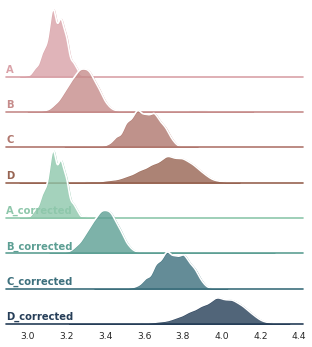

In [28]:
tm.vis.corrected_UMI_hist(adata,
                          groupby = 'danno_RNAonly',
                          groups = ['A','B','C','D'],
                          reference = 'A',
                          logUMIby = 'log10_totUMIs',
                          ratios = [1,1.8,4,6.7])